# Phase 04: Modeling

**Bài toán đặt ra**: Liệu chúng ta có thể dự đoán được nhóm thứ hạng của một đội bóng chỉ dựa vào các chỉ số về lối chơi và thành tích của đội bóng trong mùa giải?

## 1. Các thư viện cần thiết

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

pd.set_option('display.max_columns', None)

## 2. Data Preparation

### 2.1 Import data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Đầu tiên, ta sẽ đọc dữ liệu từ các file và kết hợp chúng lại thành một tập dữ liệu mới cho việc xây dựng mô hình

In [3]:
team_profile_df = pd.read_csv('/content/drive/My Drive/BT-DS/Intro2DS/team_profile.csv')
team_ranking_df = pd.read_csv('/content/drive/My Drive/BT-DS/Intro2DS/team_rankings.csv')
match_overview_df = pd.read_csv('/content/drive/My Drive/BT-DS/Intro2DS/match_overview.csv', sep='\t')
match_statistic_df = pd.read_csv('/content/drive/My Drive/BT-DS/Intro2DS/match_statistics.csv', sep='\t')

In [4]:
overview_statistic_df = pd.merge(match_overview_df,match_statistic_df, left_on=['Match ID'], right_on=['match_id'])
overview_statistic_df.drop(columns=['match_id'], inplace=True)
overview_statistic_df.head()

,Match ID,Date,Season,Home Team,Away Team,Home Lineup,Away Lineup,Fulltime Score,Winner,home_total_shots,home_shots_saved,home_corners,home_free_kicks,home_offsides,home_fouls,away_total_shots,away_shots_saved,away_corners,away_free_kicks,away_offsides,away_fouls,home_cards,away_cards
0,3050173,2018-08-11,18/19,Newcastle United,Tottenham Hotspur,4-4-1-1,4-3-2-1,1:2,Tottenham Hotspur,2,4,3,12,11,1,6,1,5,12,12,0,2,2
1,3050169,2018-08-11,18/19,Fulham FC,Crystal Palace,4-3-3,4-4-2,0:2,Crystal Palace,6,7,5,14,8,2,9,6,5,10,11,3,1,2
2,3050168,2018-08-11,18/19,AFC Bournemouth,Cardiff City,4-4-2,4-1-4-1,2:0,AFC Bournemouth,3,1,7,10,12,0,1,0,4,12,8,2,1,1
3,3050176,2018-08-11,18/19,Wolverhampton Wanderers,Everton FC,3-4-3,4-2-3-1,2:2,Draw,4,3,3,10,7,2,5,2,6,9,7,3,0,3
4,3050172,2018-08-10,18/19,Manchester United,Leicester City,4-1-4-1,4-4-2,2:1,Manchester United,6,3,2,9,11,4,4,4,5,15,7,2,2,1


In [5]:
home_stats = overview_statistic_df.groupby(['Season', 'Home Team']).agg(
    total_home_shots=('home_total_shots', 'sum'),
    total_home_shots_saved=('home_shots_saved', 'sum'),
    total_home_corners=('home_corners', 'sum'),
    total_home_free_kicks=('home_free_kicks', 'sum'),
    total_home_offsides=('home_offsides', 'sum'),
    total_home_fouls=('home_fouls', 'sum')
).reset_index()

away_stats = overview_statistic_df.groupby(['Season', 'Away Team']).agg(
    total_away_shots=('away_total_shots', 'sum'),
    total_away_shots_saved=('away_shots_saved', 'sum'),
    total_away_corners=('away_corners', 'sum'),
    total_away_free_kicks=('away_free_kicks', 'sum'),
    total_away_offsides=('away_offsides', 'sum'),
    total_away_fouls=('away_fouls', 'sum')
).reset_index()

home_stats = home_stats.rename(columns={'Home Team': 'Club'})
away_stats = away_stats.rename(columns={'Away Team': 'Club'})
team_stats_df = pd.merge(home_stats, away_stats, on=['Season', 'Club'], how='inner')

team_stats_df['total_shots'] = team_stats_df['total_home_shots'] + team_stats_df['total_away_shots']
team_stats_df['total_shots_saved'] = team_stats_df['total_home_shots_saved'] + team_stats_df['total_away_shots_saved']
team_stats_df['total_corners'] = team_stats_df['total_home_corners'] + team_stats_df['total_away_corners']
team_stats_df['total_free_kicks'] = team_stats_df['total_home_free_kicks'] + team_stats_df['total_away_free_kicks']
team_stats_df['total_offsides'] = team_stats_df['total_home_offsides'] + team_stats_df['total_away_offsides']
team_stats_df['total_fouls'] = team_stats_df['total_home_fouls'] + team_stats_df['total_away_fouls']

stats_df = team_stats_df[['Season', 'Club', 'total_shots', 'total_shots_saved', 'total_corners', 'total_free_kicks', 'total_offsides', 'total_fouls']]
stats_df.head()


,Season,Club,total_shots,total_shots_saved,total_corners,total_free_kicks,total_offsides,total_fouls
0,14/15,Arsenal FC,218,97,245,459,346,55
1,14/15,Aston Villa,128,114,153,493,374,64
2,14/15,Burnley FC,120,133,155,459,392,57
3,14/15,Chelsea FC,210,85,201,447,323,61
4,14/15,Crystal Palace,125,84,183,421,460,65


In [6]:
# merge team_ranking_df và team_profile_df
team_ranking_df = team_ranking_df.rename(columns={'Team': 'Club'})
final_merged_df = team_profile_df.merge(team_ranking_df, on=['Season', 'Club'], how='inner')

# merge với match_statistic_df
new_df = pd.merge(final_merged_df, stats_df, on=['Season', 'Club'], how='inner')
print(f'Dữ liệu có {new_df.shape[0]} dòng và {new_df.shape[1]} cột.')
new_df.head()

Dữ liệu có 200 dòng và 18 cột.


,Season,Club,Squad,Average age,Foreigners,Total market value,Ranking,Wins,Draws,Losses,Goals Scored,Goals Conceded,total_shots,total_shots_saved,total_corners,total_free_kicks,total_offsides,total_fouls
0,14/15,Chelsea FC,38,25.4,28,0.358592,1,26,9,3,73,32,210,85,201,447,323,61
1,14/15,Manchester United,43,25.4,26,0.321752,4,20,10,8,62,37,169,93,188,442,403,77
2,14/15,Manchester City,34,27.1,27,0.281147,2,24,7,7,83,38,222,81,257,378,410,69
3,14/15,Arsenal FC,42,24.5,29,0.257345,3,22,9,7,71,36,218,97,245,459,346,55
4,14/15,Liverpool FC,35,24.8,21,0.193470,6,18,8,12,52,48,187,89,184,490,349,68


### 2.2 Feature Engineering

#### 1. Tạo biến dự đoán

Chúng em nhóm các đội bóng theo thứ hạng để giúp mô hình học máy có thể phân loại chính xác hơn các đội bóng vào các nhóm khác nhau dựa trên thành tích thi đấu của các đội bóng đó.

Cụ thể, nhóm thứ hạng dựa trên các mức độ `ranking` như sau:

- **Nhóm 1** (Top 1-5): Các đội bóng có thứ hạng cao nhất, thể hiện thành tích xuất sắc trong mùa giải.
- **Nhóm 2** (Top 6-10): Các đội bóng có thành tích khá tốt, nhưng chưa đạt được thành tích xuất sắc như nhóm 1.
- **Nhóm 3** (Top 11-15): Các đội bóng ở mức trung bình, chưa thể hiện được sự vượt trội nhưng vẫn duy trì được một mức độ ổn định.
- **Nhóm 4** (Top 16 trở lên): Các đội bóng có thành tích kém hơn, chủ yếu ở vị trí thấp trong bảng xếp hạng.

In [7]:
bins = [0, 5, 10, 15, 25] # các nhóm thứ hạng
labels = [1, 2, 3, 4] # các nhãn tương ứng
new_df['Ranking_Group'] = pd.cut(new_df['Ranking'], bins=bins, labels=labels, right=False)
# loại bỏ cột ranking
new_df.drop(columns=['Ranking'], inplace=True)

Xem lại dữ liệu với mùa giải cụ thể

In [8]:
new_df[new_df['Season'] == '20/21'].sort_values(by='Ranking_Group')

,Season,Club,Squad,Average age,Foreigners,Total market value,Wins,Draws,Losses,Goals Scored,Goals Conceded,total_shots,total_shots_saved,total_corners,total_free_kicks,total_offsides,total_fouls,Ranking_Group
120,20/21,Manchester City,36,25.3,23,0.701588,27,5,6,83,32,556,62,225,354,339,53,1
121,20/21,Liverpool FC,43,24.9,28,0.651604,20,9,9,68,42,592,96,250,305,386,63,1
122,20/21,Chelsea FC,39,25.7,23,0.594444,19,10,9,58,36,546,70,224,351,423,74,1
123,20/21,Manchester United,39,25.4,25,0.509787,21,11,6,73,44,508,98,190,372,430,71,1
124,20/21,Tottenham Hotspur,41,25.2,23,0.462503,18,8,12,68,45,428,111,165,458,433,44,2
125,20/21,Arsenal FC,42,24.9,27,0.402643,18,7,13,55,39,434,92,197,374,330,58,2
127,20/21,Leicester City,40,25.8,26,0.325447,20,6,12,68,50,463,87,206,410,387,72,2
135,20/21,Leeds United,39,25.1,24,0.131834,18,5,15,62,54,522,148,229,409,432,76,2
130,20/21,West Ham United,39,27.0,23,0.200611,19,8,11,62,47,454,107,164,348,370,71,2
136,20/21,Crystal Palace,36,28.2,18,0.100394,12,8,18,41,66,338,107,143,413,396,65,3


#### 2. Tạo thêm các đặc trưng mới để cải thiện mô hình dự đoán

Để cải thiện hiệu suất của mô hình dự đoán các **nhóm thứ hạng (Ranking Group)**, chúng ta sẽ tạo một đặc trưng mới có tên là `points`. Đặc trưng này được tính toán dựa trên số trận thắng, hòa, và thua của các đội bóng, theo công thức:

**points = 3 × Wins + 1 × Draws + 0 × Losses**

Lý do thực hiện:

- Thay vì sử dụng ba cột riêng biệt là `Wins`, `Draws`, và `Losses`, chúng ta sẽ kết hợp các dữ liệu trong các cột này thành một cột duy nhất từ đó giúp giảm độ phức tạp của dữ liệu và tăng khả năng tổng quát của mô hình.

- Hơn nữa, thứ hạng của đội bóng có mối tương quan chặt chẽ với số điểm đạt được trong mùa giải, việc tạo và sử dụng đặc trưng `points` giúp mô hình dễ dàng học được mối quan hệ giữa đặc trưng này và thứ hạng.

In [9]:
new_df['points'] = 3 * new_df['Wins'] + 1 * new_df['Draws'] + 0 * new_df['Losses']

# Xóa các cột không còn cần thiết
new_df = new_df.drop(columns=['Wins', 'Draws', 'Losses'])
new_df.head()

,Season,Club,Squad,Average age,Foreigners,Total market value,Goals Scored,Goals Conceded,total_shots,total_shots_saved,total_corners,total_free_kicks,total_offsides,total_fouls,Ranking_Group,points
0,14/15,Chelsea FC,38,25.4,28,0.358592,73,32,210,85,201,447,323,61,1,87
1,14/15,Manchester United,43,25.4,26,0.321752,62,37,169,93,188,442,403,77,1,70
2,14/15,Manchester City,34,27.1,27,0.281147,83,38,222,81,257,378,410,69,1,79
3,14/15,Arsenal FC,42,24.5,29,0.257345,71,36,218,97,245,459,346,55,1,75
4,14/15,Liverpool FC,35,24.8,21,0.193470,52,48,187,89,184,490,349,68,2,62



Ở đây ta sẽ thực hiện việc tạo các đặc trưng mới bằng cách chuyển đổi giá trị của các đặc trưng như: `total_shots`, `total_shots_saved`,	`total_corners`,	`total_free_kicks`,`total_offsides`,`total_foul` thành các đặc trưng mang ý nghĩa xếp hạng so sánh giữa các đội bóng. Phương pháp này giúp các đặc trưng phản ánh rõ hơn sự khác biệt giữa các đội trong mỗi mùa giải, hỗ trợ các mô hình dự đoán học được các quy luật dễ dàng hơn và đưa ra kết quả chính xác hơn.

In [10]:
columns_to_rank = ['total_shots', 'total_shots_saved', 'total_corners',
                   'total_free_kicks', 'total_offsides', 'total_fouls']

for column in columns_to_rank:
    new_df[column + '_rank'] = new_df.groupby('Season')[column].rank()
    new_df.drop(columns=[column], inplace=True)

new_df.head()

,Season,Club,Squad,Average age,Foreigners,Total market value,Goals Scored,Goals Conceded,Ranking_Group,points,total_shots_rank,total_shots_saved_rank,total_corners_rank,total_free_kicks_rank,total_offsides_rank,total_fouls_rank
0,14/15,Chelsea FC,38,25.4,28,0.358592,73,32,1,87,18.0,5.0,15.0,7.0,1.0,9.0
1,14/15,Manchester United,43,25.4,26,0.321752,62,37,1,70,15.0,7.5,12.0,6.0,12.0,18.0
2,14/15,Manchester City,34,27.1,27,0.281147,83,38,1,79,20.0,3.0,20.0,1.0,15.0,15.5
3,14/15,Arsenal FC,42,24.5,29,0.257345,71,36,1,75,19.0,10.0,19.0,12.5,3.0,4.0
4,14/15,Liverpool FC,35,24.8,21,0.193470,52,48,2,62,17.0,6.0,10.0,18.0,4.0,13.5


### 2.3 Chuẩn hóa dữ liệu

**Đối với các cột dạng số**

Chúng em không chuẩn hóa dữ liệu dạng số ở đây vì các mô hình học máy như **Decision Trees**, **Random Forests** và **XGBoost** không yêu cầu chuẩn hóa. Các mô hình cây quyết định không bị ảnh hưởng bởi phạm vi của các đặc trưng, vì chúng không sử dụng khoảng cách giữa các điểm dữ liệu. Do đó, chuẩn hóa không cần thiết và giúp giảm thiểu công sức tiền xử lý mà không làm ảnh hưởng đến hiệu suất mô hình.


**Với các cột dạng phân loại**

Vì các mô hình học máy chỉ hoạt động hiệu quả khi các đặc trưng đưa đầu vào đều được chuyển thành dạng số, ta sẽ thực hiện **Label Encoding** cho hai cột phân loại là `Season` và `Club`.

In [11]:
from sklearn.preprocessing import LabelEncoder

# Khởi tạo LabelEncoder
label_encoder_season = LabelEncoder()
label_encoder_club = LabelEncoder()

# mã hóa cột 'Season'
new_df['Season_encoded'] = label_encoder_season.fit_transform(new_df['Season'])
# mã hóa cột 'Club'
new_df['Club_encoded'] = label_encoder_club.fit_transform(new_df['Club'])

encoded_season_info = new_df[['Season', 'Season_encoded']].drop_duplicates().reset_index(drop=True).set_index('Season')
encoded_season_info.sort_values(by='Season_encoded')

,Season_encoded
Season,
14/15,0
15/16,1
16/17,2
17/18,3
18/19,4
19/20,5
20/21,6
21/22,7
22/23,8


In [12]:
encoded_club_info = new_df[['Club', 'Club_encoded']].drop_duplicates().reset_index(drop=True).set_index('Club')
encoded_club_info.sort_values(by='Club_encoded').sort_values(by='Club_encoded')

,Club_encoded
Club,
AFC Bournemouth,0
Arsenal FC,1
Aston Villa,2
Brentford FC,3
Brighton & Hove Albion,4
Burnley FC,5
Cardiff City,6
Chelsea FC,7
Crystal Palace,8


Kiểm tra lại dữ liệu sau khi chuẩn hóa

In [13]:
new_df.drop(columns=['Season', 'Club'], inplace=True)
new_df.rename(columns={'Season_encoded': 'Season', 'Club_encoded': 'Club'}, inplace=True)
new_df.head()

,Squad,Average age,Foreigners,Total market value,Goals Scored,Goals Conceded,Ranking_Group,points,total_shots_rank,total_shots_saved_rank,total_corners_rank,total_free_kicks_rank,total_offsides_rank,total_fouls_rank,Season,Club
0,38,25.4,28,0.358592,73,32,1,87,18.0,5.0,15.0,7.0,1.0,9.0,0,7
1,43,25.4,26,0.321752,62,37,1,70,15.0,7.5,12.0,6.0,12.0,18.0,0,18
2,34,27.1,27,0.281147,83,38,1,79,20.0,3.0,20.0,1.0,15.0,15.5,0,17
3,42,24.5,29,0.257345,71,36,1,75,19.0,10.0,19.0,12.5,3.0,4.0,0,1
4,35,24.8,21,0.193470,52,48,2,62,17.0,6.0,10.0,18.0,4.0,13.5,0,15


#### 2.4 Kiểm tra độ tương quan các cột

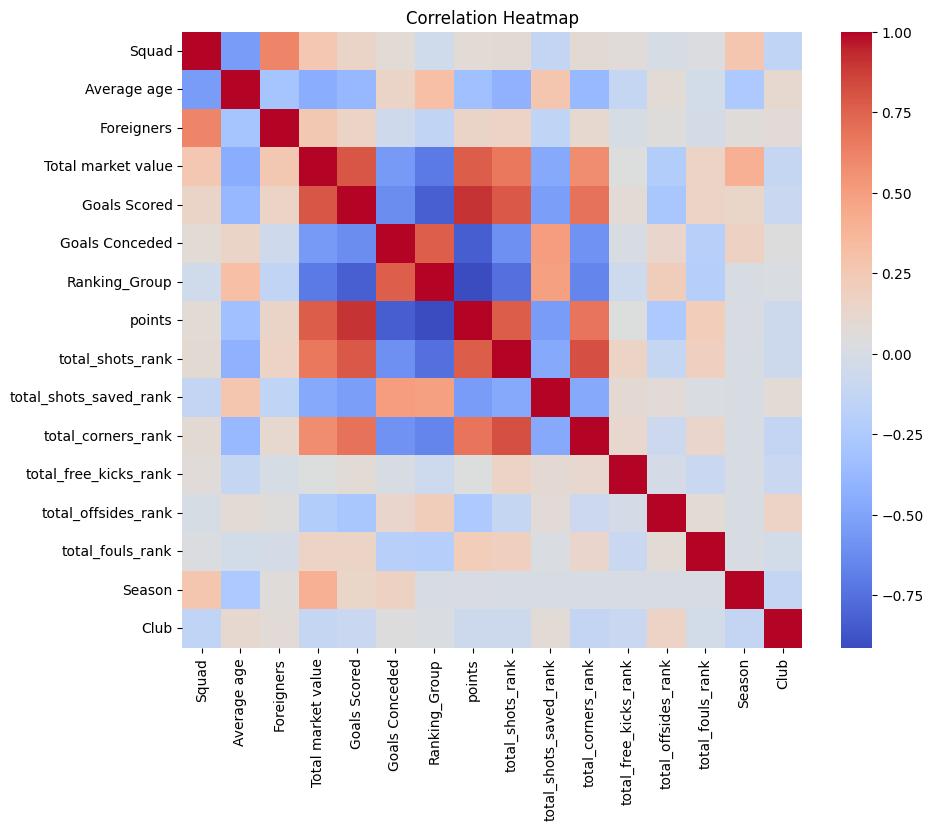

In [14]:
# thực hiện vẽ biểu đồ tương quan g4iữa các cột
plt.figure(figsize=(10, 8))
sns.heatmap(new_df.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Từ ma trận tương quan trên, ta có thể thấy:

- Các cột có độ tương quan mạnh với `Ranking_Group` là `Total market value`, `Goal Scored`, `Goal Conceded`, `points`,  `total_shots_rank`, `total_shots_saved_rank` và `total_corner_rank`.

- Với `Total market value`, `Goal Scored`, `points`, `total_shots_rank` và `total_corner_rank` là các đặc trưng có tương quan âm với `Ranking_Group`, nghĩa là các chỉ số của các cột này càng cao thì giá trị của `Ranking_Group` càng nhỏ. Điều này có ý nghĩa là khi các chỉ số này càng cao thì nhóm thứ hạng của đội bóng đó thuộc về càng cao.

- Với `Goal Conceded`, `total_shots_saved_rank` là các đặc trưng có tương quan dương với `Ranking_Group`, nghĩa là các chỉ số của các cột này càng cao thì giá trị của `Ranking_Group` càng cao. Điều này có ý nghĩa là khi các chỉ số này càng cao thì nhóm thứ hạng của đội bóng càng thấp.

- Các đặc trưng còn lại như `Average age`, `total_offsides_rank`, `total_fouls_rank cũng có ảnh hưởng đến Ranking_Group` ở mức độ nhất định.

- Các đặc trưng như `Squad`, `total_free_kicks_ranks` chỉ số tương quan rất yếu, ta có thể xem xét bỏ các đặc trưng này.

In [15]:
new_df.drop(columns=['Squad', 'total_free_kicks_rank'], inplace=True)

#### 2.5 Kiểm tra phân phối các lớp của biến mục tiêu


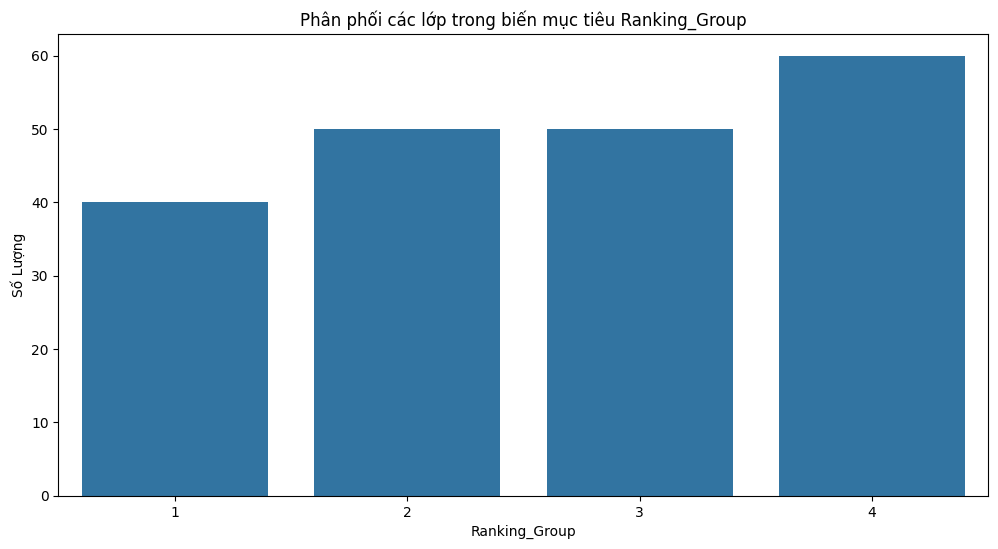

Ranking_Group
4    60
2    50
3    50
1    40
Name: count, dtype: int64


In [16]:
plt.figure(figsize=(12,6))
sns.countplot(x='Ranking_Group', data=new_df)
plt.title('Phân phối các lớp trong biến mục tiêu Ranking_Group')
plt.xlabel('Ranking_Group')
plt.ylabel('Số Lượng')
plt.xticks()
plt.show()

# In số lượng mẫu mỗi lớp
print(new_df['Ranking_Group'].value_counts())

- Phân phối số lượng mẫu trong các lớp của biến mục tiêu **Ranking_Group** là khá cân bằng, với số lượng mẫu tương đối đồng đều giữa các lớp vì vậy các mô hình có thể hoạt động ổn định và không gặp phải vấn đề lớn về mất cân bằng lớp.

 - Tuy nhiên vẫn có sự chênh lệch nhất định giữa các lớp và do sự hạn chế của dữ liệu (chỉ có 200 dòng), nên ta sẽ chấp nhận kết quả nên ta sẽ chấp nhận kết quả với độ chính xác tương đối không quá cao.

## 3. Chia dữ liệu thành tập huấn luyện và kiểm tra

Chúng em sẽ chia dữ liệu thành 3 tập cho việc xây dựng và đánh giá mô hình: `train`, `val` và `test`:
- Tập huấn luyện (Train): Dùng để huấn luyện mô hình.
- Tập validation: Dùng để đánh giá mô hình.
- Tập kiểm tra (Test): Dùng để kiểm tra, đánh giá chất lượng mô hình sau khi huấn luyện.

#### 3.1 Trước tiên, chia dữ liệu thành 2 phần: một phần lớn cho test và validation, và phần còn lại cho test.

In [17]:
from sklearn.model_selection import train_test_split

# Tách các biến độc lập (X) và biến phụ thuộc (y)
X = new_df.drop(columns=['Ranking_Group'])
y = new_df['Ranking_Group']

# Chia dữ liệu thành 80% train+val và 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Kiểm tra kích thước của tập huấn luyện và tập kiểm tra
print(f'Kích thước tập train + validation: {X_train_val.shape}')
print(f'Kích thước tập train + validation: {y_train_val.shape}')
print(f'Kích thước tập test: {X_test.shape}')
print(f'Kích thước tập test: {y_test.shape}')

Kích thước tập train + validation: (160, 13)
Kích thước tập train + validation: (160,)
Kích thước tập test: (40, 13)
Kích thước tập test: (40,)


#### Sau khi đã có phần dữ liệu train + val, ta tiếp tục chia phần này thành tập train và tập val.

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(f'Kích thước tập train: {X_train.shape}')
print(f'Kích thước tập train: {y_train.shape}')
print(f'Kích thước tập test: {X_val.shape}')
print(f'Kích thước tập test: {y_val.shape}')

Kích thước tập train: (128, 13)
Kích thước tập train: (128,)
Kích thước tập test: (32, 13)
Kích thước tập test: (32,)


## 4. Huấn luyện mô hình và đánh giá

Nhóm em sẽ chọn sử dụng các mô hình **Decision Trees**, **Random Forests**, và **XGBoost** để phân nhóm dữ liệu **Ranking_Group** vì những lý do sau:

- 1. **Decision Trees**: đây là một mô hình đơn giản và dễ hiểu, có thể giải thích rõ ràng cách nó phân nhóm dữ liệu dựa trên các đặc trưng. Mô hình cây quyết định có khả năng xử lý các đặc trưng phân loại và số, và không yêu cầu chuẩn hóa dữ liệu. Mô hình này cũng giúp xác định các đặc trưng quan trọng nhất để phân nhóm.

- 2. **Random Forests**: Random Forest là một mô hình ensemble, bao gồm nhiều cây quyết định. Việc kết hợp các cây quyết định giúp giảm thiểu overfitting và tăng tính tổng quát của mô hình. Đây là một phương pháp mạnh mẽ khi làm việc với dữ liệu có tính đa dạng và phức tạp, như trong bài toán phân nhóm này.

- 3. **XGBoost**: XGBoost là một mô hình gradient boosting mạnh mẽ, hiệu quả trong việc xử lý các bài toán phân loại phức tạp. Mô hình này đặc biệt nổi bật về khả năng tối ưu hóa và độ chính xác cao. XGBoost có thể xử lý được các vấn đề như không cân bằng lớp, và còn có khả năng điều chỉnh và chọn lựa các đặc trưng quan trọng từ dữ liệu.

Với độ đo mà chúng em sẽ sử dụng ở đây là **đo độ chính xác (Accuracy)**: là tỷ lệ giữa số lượng dự đoán đúng và tổng số mẫu trong bài toán phân loại. Đây là một chỉ số đơn giản và dễ hiểu, giúp đánh giá hiệu quả của mô hình trong việc phân nhóm đúng các đối tượng vào các lớp mục tiêu.

Ba mô hình trên đều phù hợp với bài toán phân nhóm dữ liệu **Ranking_Group** vì chúng có khả năng xử lý tốt các đặc trưng số và phân loại, dễ dàng điều chỉnh và tối ưu hóa, đồng thời có khả năng tổng quát cao, giúp đạt được kết quả chính xác hơn trong việc phân nhóm các đội bóng dựa trên thứ hạng.

#### 4.1 Mô hình Decision Tree


In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# khởi tạo mô hình
dt_model = DecisionTreeClassifier(random_state=42)

# huấn luyện mô hình trên tập huấn luyện
dt_model.fit(X_train, y_train)

# kiểm tra lại trên tập validation
y_pred_dt = dt_model.predict(X_val)

# đánh giá độ chính xác của mô hình
accuracy_dt = accuracy_score(y_val, y_pred_dt)
print(f"Accuracy của mô hình Decision Tree trên tập validation là: {accuracy_dt:.5f}")
print(classification_report(y_val, y_pred_dt))

Accuracy của mô hình Decision Tree trên tập validation là: 0.78125
              precision    recall  f1-score   support

           1       0.88      1.00      0.93         7
           2       0.56      0.71      0.62         7
           3       0.71      0.56      0.62         9
           4       1.00      0.89      0.94         9

    accuracy                           0.78        32
   macro avg       0.79      0.79      0.78        32
weighted avg       0.80      0.78      0.78        32



#### 4.2 Mô hình Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

# khởi tạo mô hình
rf_model = RandomForestClassifier(random_state=42)

# huấn luyện mô hình trên tập huấn luyện
rf_model.fit(X_train, y_train)

# dự đoán trên tập validation
y_pred_rf = rf_model.predict(X_val)

# đánh giá độ chính xác của mô hình
accuracy_rf = accuracy_score(y_val, y_pred_rf)
print(f"Accuracy của mô hình Random Forest trên tập validation là: {accuracy_rf:.5f}")
print(classification_report(y_val, y_pred_rf))

Accuracy của mô hình Random Forest trên tập validation là: 0.81250
              precision    recall  f1-score   support

           1       0.88      1.00      0.93         7
           2       0.67      0.86      0.75         7
           3       0.75      0.67      0.71         9
           4       1.00      0.78      0.88         9

    accuracy                           0.81        32
   macro avg       0.82      0.83      0.82        32
weighted avg       0.83      0.81      0.81        32



#### 4.3 Mô hình XGBoost

In [21]:
import xgboost as xgb
encoder = LabelEncoder()
# khởi tạo mô hình
xgb_model = xgb.XGBClassifier(random_state=42)

# chuyển đổi y_train và y_val
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)

# huấn luyện mô hình trên tập huấn luyện
xgb_model.fit(X_train, y_train_encoded)

# dự đoán trên tập validation
y_pred_xgb = xgb_model.predict(X_val)

# đánh giá độ chính xác của mô hình
accuracy_xgb = accuracy_score(y_val_encoded, y_pred_xgb)
print(f"Accuracy của mô hình XGBoost trên tập validation là: {accuracy_xgb:.5f}")
print(classification_report(y_val_encoded, y_pred_xgb))

Accuracy của mô hình XGBoost trên tập validation là: 0.81250
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       0.60      0.86      0.71         7
           2       0.83      0.56      0.67         9
           3       1.00      0.89      0.94         9

    accuracy                           0.81        32
   macro avg       0.83      0.83      0.81        32
weighted avg       0.84      0.81      0.81        32



Dựa trên kết quả của ba mô hình, chúng ta có:

- **Mô hình Decision Tree**: Accuracy = 78.13%
- **Mô hình Random Forest**: Accuracy = 81.25%
- **Mô hình XGBoost**: Accuracy = 81.25%

#### **Đánh giá**
- Dựa trên độ chính xác (accuracy) của ba mô hình, cả **Random Forest** và **XGBoost** đều đạt độ chính xác cao nhất (81.25%) cho thấy rằng mô hình đã dự đoán đúng phần lớn các lớp mục tiêu, chỉ ra rằng mô hình có khả năng phân loại tốt với các đặc trưng đã được cung cấp.

- Tuy nhiên, XGBoost thường có khả năng vượt trội hơn về hiệu suất trong các bài toán phân loại phức tạp do khả năng tối ưu hóa và xử lý các mối quan hệ phi tuyến tính tốt hơn.

XGBoost và Random Forest hiệu quả hơn so với Decision Tree bởi vì:
- **Random Forest** là một mô hình học máy ensemble, hoạt động bằng cách kết hợp nhiều cây quyết định (decision trees). Nó giảm thiểu hiện tượng overfitting (quá khớp dữ liệu) nhờ việc tạo ra các cây quyết định độc lập và kết hợp kết quả của chúng. Điều này giúp mô hình này có khả năng tổng quát tốt hơn, đặc biệt với tập dữ liệu phức tạp.
- **XGBoost** sử dụng thuật toán boosting, trong đó các mô hình cây quyết định được xây dựng theo thứ tự và mỗi cây được xây dựng để sửa chữa lỗi của cây trước đó. Điều này giúp mô hình học được các đặc trưng phức tạp hơn trong dữ liệu và đưa ra dự đoán chính xác hơn.


Vì vậy, chúng em sẽ chọn  mô hình **XGBoost** - là mô hình tốt nhất ở đây:
- Nó có khả năng xử lý tốt các mối quan hệ phi tuyến tính và cải thiện độ chính xác với ít overfitting.
- XGBoost có xu hướng hoạt động ổn định và có thể dễ dàng tinh chỉnh để cải thiện kết quả so với các mô hình khác.

## 5. Dùng mô hình tìm được thực hiện dự đoán trên tập test

In [22]:
y_test = encoder.transform(y_test)

# dự đoán trên tập test
y_test_pred_xgb = xgb_model.predict(X_test)

# đánh giá độ chính xác của mô hình
accuracy = accuracy_score(y_test, y_test_pred_xgb)
print(f"Accuracy của mô hình XGBoost trên tập test là: {accuracy:.5f}")

Accuracy của mô hình XGBoost trên tập test là: 0.87500
